# Microsoft Malware detection

In this kernel, I build a LGBM model using only a subset of the training data, in order to fit in memory.

## Notebook  Content
1. [Utility functions](#0)
1. [Loading the data](#1) <br>
    2.1 [Get the files and select the variables](#2.1) <br>
    2.2 [Define the type of each variable](#2.2)
1. [Feature engineering](#2) <br>
    3.1 [Frequency encoding](#3.1) <br>
    3.2 [Label encoding](#3.2)
1. [Training the model](#3)
1. [Feature importance](#4)
1. [Submission](#5)

<a id="0"></a> <br>
## 1. Utility functions
Before starting, we define a utility function that helps managing memory.

In [1]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

<a id="1"></a> <br>
## 2. Loading the data

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

<a id="2.1"></a> <br>
### 2.1 Get the files and select the variables
Following [Theo Viel](https://www.kaggle.com/theoviel/load-the-totality-of-the-data), we set the types of each fields in the train set in order to reduce the memory usage:

In [3]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

First, we make a census of the variables, by type, and define the set we want to keep before reading the data:

In [4]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

We read the data, limiting the size of the training set to 4'000'000 rows:

In [5]:
#nrows = 2000000
#_______________________________________________________________________________
retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('train.csv',
                    usecols = retained_columns,
                    dtype = dtypes)
#_______________________________________________________________
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')


In [6]:
test = pd.read_csv('test.csv',
                   usecols = retained_columns,
                   dtype = dtypes)

<a id="2.2"></a> <br>
### 2.2 Define the type of each variable
In practice, among the numerical variables, many corresponds to identifiers. *In the current dataset, the truly numerical variables are in fact rare*. Below, I make a list of the variables which are truly numerical, according the the description of the data.

In [7]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

We also list binary variables, since they can be treated as numericals by tree methods:

In [8]:
binary_variables = [c for c in train.columns if train[c].nunique() == 2]

to finally make a census of the categorical variables:

In [9]:
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [11]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

Most of the current variables are categories and we need to choose a method to treat them. **Depending on the cardinality of each variable**, we can opt for** one-hot-encoding, frequency or target encoding**. In the particular case of Light-GBM, we can also use the **built-in LGBM treatment of categoricals**:

In [12]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

<a id="2"></a> <br>
## 3. Feature Engineering
<a id="3.1"></a> <br>
### 3.1 Frequency encoding
For variables with large cardinality, an efficient encoding consists in ranking the categories with respect to their frequencies. These variables are then treated as numerical.

In [13]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [14]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]

In [15]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████| 7/7 [04:11<00:00, 35.28s/it]


<a id="3.2"></a> <br>
### 3.2 Label encoding

In [16]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    train[col] = indexer[col].get_indexer(train[col])
    test[col] = indexer[col].get_indexer(test[col])

100%|██████████| 47/47 [34:00<00:00, 24.40s/it]


In [17]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 1528.16 Mb (66.0% reduction)
Mem. usage decreased to 1376.01 Mb (65.5% reduction)


In [18]:
train[:5]

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,0,0,0,134.0,0,0,0,NaN,0,0,0,1,0,205.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,NaN,0.0,0,-1,1.0,0,0,0,0.0,22022.0,4.0,0,135.0,-1,476940.0,0,299451.0,0,4096.0,0,18.906250,1440.0,900.0,0,-1,4.294967e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0,NaN,0,2572.0,0,NaN,0.0,0,0,0.0,0.0,0,0
1,000007535c3f730efa9ea0b7ef1bd645,0,1,1,0.0,0,0,0,NaN,0,0,0,1,1,171.0,0,1,1,0,0,0,0,0,0,0,0,1.0,0,NaN,0.0,0,-1,1.0,0,1,0,0.0,118655.0,4.0,0,134.0,-1,476940.0,0,102385.0,0,4096.0,1,13.898438,1366.0,768.0,1,-1,1.000000e+00,1,0,0,0,1,0,0,1,1,1,0,0,1,0,NaN,0.0,1,NaN,0,1415.0,0,NaN,0.0,0,0,0.0,0.0,1,0
2,000007905a28d863f6d0d597892cd692,0,0,0,336.0,0,0,0,NaN,0,0,0,1,2,673.0,0,2,2,0,0,0,0,1,0,0,1,1.0,0,NaN,0.0,0,0,1.0,0,0,0,10.0,2.0,4.0,0,191.0,-1,114473.0,1,113907.0,0,4096.0,0,21.500000,1920.0,1080.0,0,-1,4.294967e+09,0,0,0,0,0,1,1,0,2,2,1,0,0,1,NaN,0.0,0,NaN,1,184.0,0,NaN,0.0,0,0,0.0,0.0,2,0
3,00000b11598a75ea8ba1beea8459149f,0,0,0,25.0,0,0,0,NaN,0,0,0,1,3,20.0,-1,3,3,0,0,0,0,0,0,0,0,1.0,0,NaN,0.0,0,1,1.0,0,0,0,2.0,158.0,4.0,0,63.0,-1,238475.0,2,227116.0,0,4096.0,2,18.500000,1366.0,768.0,0,-1,4.294967e+09,2,0,0,0,2,0,0,0,3,3,1,0,0,1,NaN,0.0,0,NaN,2,30.0,0,NaN,0.0,0,0,0.0,0.0,2,1
4,000014a5f00daa18e76b81417eeb99fc,0,0,0,18.0,0,0,0,NaN,0,0,0,1,4,13.0,-1,4,4,0,0,0,0,1,0,0,1,1.0,0,NaN,0.0,0,0,1.0,0,1,0,2.0,2269.0,4.0,0,52.0,-1,476940.0,0,101900.0,0,6144.0,3,14.000000,1366.0,768.0,1,0,0.000000e+00,3,0,0,0,3,1,1,2,1,1,1,0,0,0,0.0,0.0,0,0.0,2,129.0,0,0.0,0.0,0,0,0.0,0.0,3,1


In [19]:
target = train['HasDetections']
del train['HasDetections']

<a id="3"></a> <br>
## 3. Training the model

In [20]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

We set the max number of iteration over folds:

In [21]:
max_iter = 5

In [22]:
gc.collect()

212860

In [23]:
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(train))
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0


/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731936	valid_1's auc: 0.728323
[200]	training's auc: 0.739502	valid_1's auc: 0.732781
[300]	training's auc: 0.743947	valid_1's auc: 0.734529
[400]	training's auc: 0.747035	valid_1's auc: 0.735407
[500]	training's auc: 0.749564	valid_1's auc: 0.735908
[600]	training's auc: 0.751674	valid_1's auc: 0.736162
[700]	training's auc: 0.753418	valid_1's auc: 0.736238
[800]	training's auc: 0.754896	valid_1's auc: 0.736223
[900]	training's auc: 0.756485	valid_1's auc: 0.736355
[1000]	training's auc: 0.757862	valid_1's auc: 0.736302
[1100]	training's auc: 0.759162	valid_1's auc: 0.73626
Early stopping, best iteration is:
[915]	training's auc: 0.756745	valid_1's auc: 0.73637
time elapsed: 1.5  s
fold n°1


/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731602	valid_1's auc: 0.728383
[200]	training's auc: 0.739268	valid_1's auc: 0.732842
[300]	training's auc: 0.743746	valid_1's auc: 0.734618
[400]	training's auc: 0.746779	valid_1's auc: 0.735376
[500]	training's auc: 0.749208	valid_1's auc: 0.735781
[600]	training's auc: 0.751242	valid_1's auc: 0.736011
[700]	training's auc: 0.75307	valid_1's auc: 0.736185
[800]	training's auc: 0.754673	valid_1's auc: 0.736239
[900]	training's auc: 0.756077	valid_1's auc: 0.73628
[1000]	training's auc: 0.757576	valid_1's auc: 0.736398
[1100]	training's auc: 0.758895	valid_1's auc: 0.736387
Early stopping, best iteration is:
[993]	training's auc: 0.757498	valid_1's auc: 0.736406
time elapsed: 2.8  s
fold n°2


/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.732123	valid_1's auc: 0.728598
[200]	training's auc: 0.739481	valid_1's auc: 0.732768
[300]	training's auc: 0.743997	valid_1's auc: 0.734586
[400]	training's auc: 0.746797	valid_1's auc: 0.735201
[500]	training's auc: 0.749195	valid_1's auc: 0.735553
[600]	training's auc: 0.751374	valid_1's auc: 0.735881
[700]	training's auc: 0.753161	valid_1's auc: 0.73601
[800]	training's auc: 0.7548	valid_1's auc: 0.736101
[900]	training's auc: 0.756252	valid_1's auc: 0.736102
[1000]	training's auc: 0.757613	valid_1's auc: 0.736091
Early stopping, best iteration is:
[877]	training's auc: 0.755958	valid_1's auc: 0.73613
time elapsed: 4.1  s
fold n°3


/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731784	valid_1's auc: 0.729294
[200]	training's auc: 0.73939	valid_1's auc: 0.733822
[300]	training's auc: 0.74359	valid_1's auc: 0.735348
[400]	training's auc: 0.74676	valid_1's auc: 0.736168
[500]	training's auc: 0.749039	valid_1's auc: 0.736506
[600]	training's auc: 0.751102	valid_1's auc: 0.73682
[700]	training's auc: 0.752901	valid_1's auc: 0.736905
[800]	training's auc: 0.754587	valid_1's auc: 0.736992
[900]	training's auc: 0.756064	valid_1's auc: 0.737002
[1000]	training's auc: 0.757417	valid_1's auc: 0.736984
Early stopping, best iteration is:
[832]	training's auc: 0.75513	valid_1's auc: 0.737032
time elapsed: 5.5  s
fold n°4


/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1184: UserWarning:

Using categorical_feature in Dataset.

/home/admin/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:742: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 200 rounds.
[100]	training's auc: 0.731944	valid_1's auc: 0.728205
[200]	training's auc: 0.739643	valid_1's auc: 0.732771
[300]	training's auc: 0.744289	valid_1's auc: 0.734677
[400]	training's auc: 0.74738	valid_1's auc: 0.735472
[500]	training's auc: 0.749765	valid_1's auc: 0.735887
[600]	training's auc: 0.751781	valid_1's auc: 0.736098
[700]	training's auc: 0.753558	valid_1's auc: 0.736161
[800]	training's auc: 0.755165	valid_1's auc: 0.736234
[900]	training's auc: 0.756683	valid_1's auc: 0.736281
[1000]	training's auc: 0.758098	valid_1's auc: 0.736315
[1100]	training's auc: 0.759314	valid_1's auc: 0.736259
Early stopping, best iteration is:
[988]	training's auc: 0.757935	valid_1's auc: 0.736321
time elapsed: 7.2  s
CV score: 0.73645 


<a id="4"></a> <br>
## 4. Feature importance

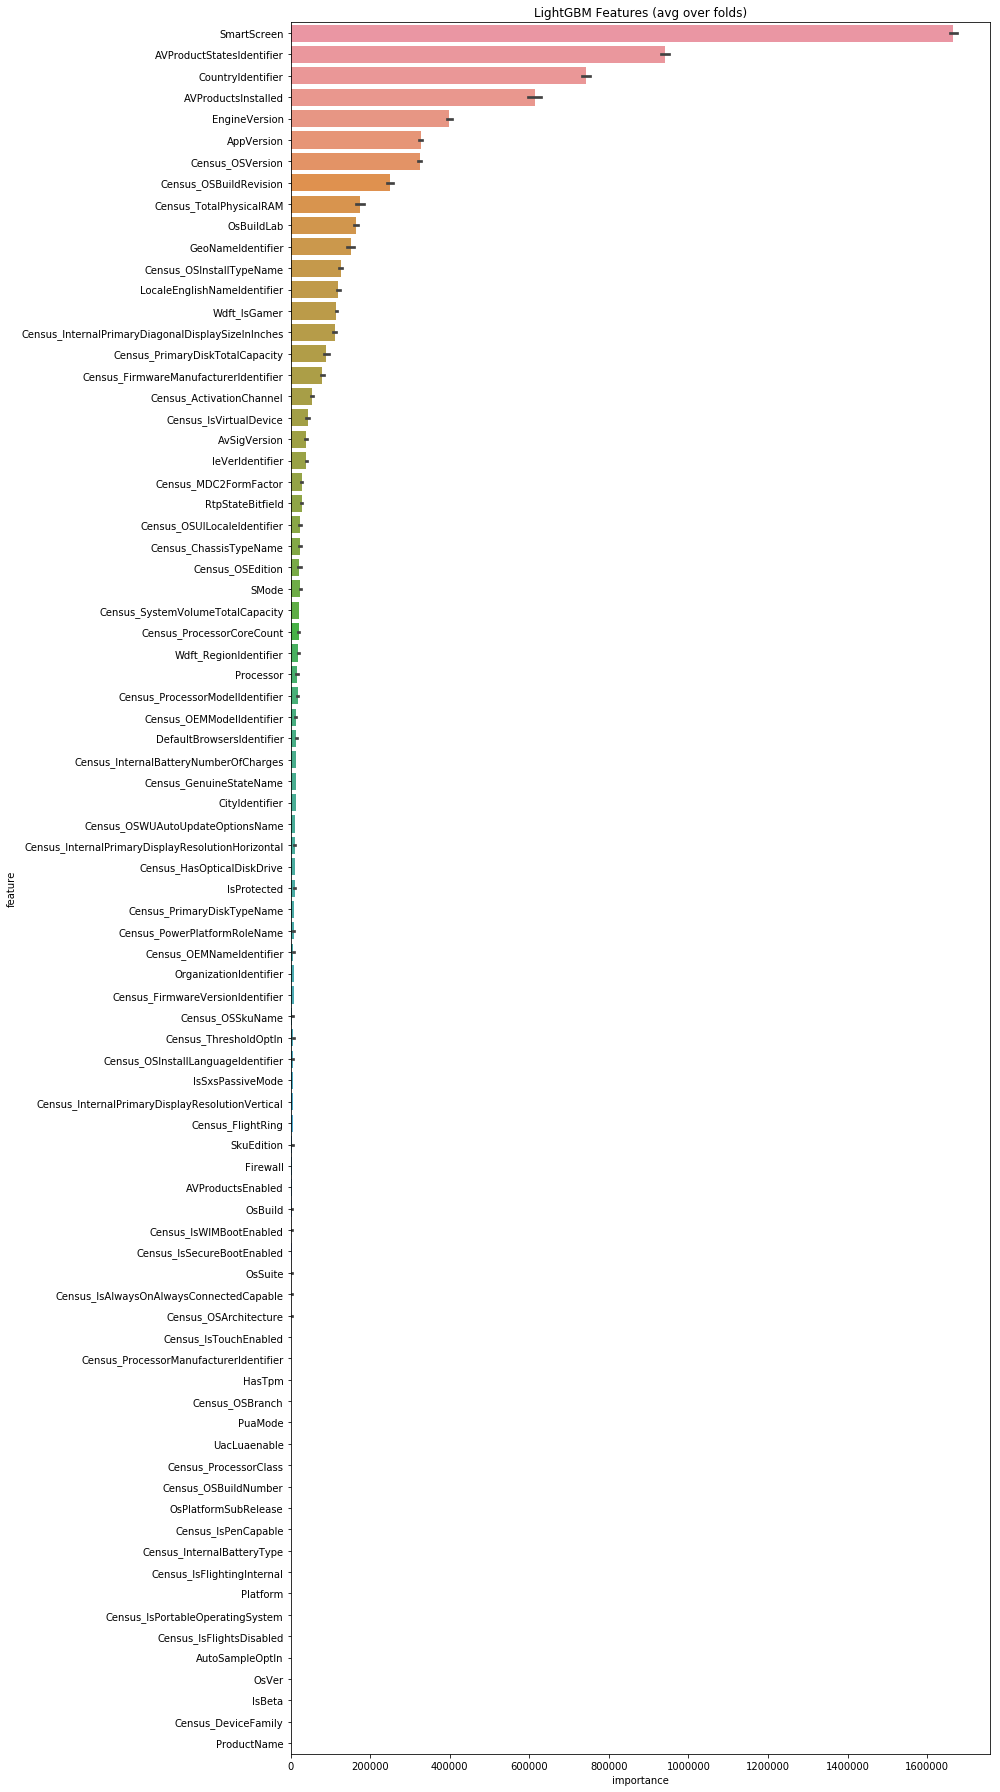

In [24]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

<a id="5"></a> <br>
## 5. Submission

In [25]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.554078
1,00000176ac758d54827acd545b6315a5,0.512395
2,0000019dcefc128c2d4387c1273dae1d,0.449363
3,0000055553dc51b1295785415f1a224d,0.342940
4,00000574cefffeca83ec8adf9285b2bf,0.447614
5,000007ffedd31948f08e6c16da31f6d1,0.575379
6,000008f31610018d898e5f315cdf1bd1,0.266515
7,00000a3c447250626dbcc628c9cbc460,0.164011
8,00000b6bf217ec9aef0f68d5c6705897,0.309334
9,00000b8d3776b13e93ad83676a28e4aa,0.356374


In [36]:
from datetime import datetime as dt
score=metrics.roc_auc_score(target, oof)
filename = 'subm_{:.6f}_{}_{}.csv'.format(score, 'Feature_Encoding_LGBM', dt.now().strftime('%Y-%m-%d-%H-%M'))
sub_df.to_csv(filename, index=False)